## Fine-Tuning OPT from Scratch

In [17]:
import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
import math
import torch.nn as nn
import pandas as pd
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


- Get the Data from the original Github repo which introduced QLoRa

In [2]:
import requests 

url = "https://github.com/microsoft/LoRA/raw/main/examples/NLG/data/e2e/test.txt"
output_file = "test.txt"

response = requests.get(url)
with open(output_file, "wb") as file:
    file.write(response.content)


In [3]:
import sys
import io 
import json

#==========Function to change the format of the data from .txt--->.json
def change_format(read_file, write_file):
    with open(read_file,'r', encoding='utf-8') as reader, \
        open(write_file, 'w', encoding='utf-8') as writer:
        for line in reader:
            items = line.strip().split("||")
            context = items[0]
            completion = items[1].strip("\n")
            x = {}
            x["context"] = context
            x["completion"] = completion
            writer.write(json.dumps(x) + "\n")

change_format("train.txt", "train_changed.json1")
change_format("test.txt", "test_changed.json1")
        

- Print some lines from the train data

In [4]:
with open("train_changed.json1", "r") as f:
    for _  in range(5):
        print(next(f))

{"context": "name : The Vaults | Type : pub | price : more than \u00a3 30 | customer rating : 5 out of 5 | near : Caf\u00e9 Adriatic", "completion": "The Vaults pub near Caf\u00e9 Adriatic has a 5 star rating . Prices start at \u00a3 30 ."}

{"context": "name : The Cambridge Blue | Type : pub | food : English | price : cheap | near : Caf\u00e9 Brazil", "completion": "Close to Caf\u00e9 Brazil , The Cambridge Blue pub serves delicious Tuscan Beef for the cheap price of \u00a3 10.50 . Delicious Pub food ."}

{"context": "name : The Eagle | Type : coffee shop | food : Japanese | price : less than \u00a3 20 | customer rating : low | area : riverside | family friendly : yes | near : Burger King", "completion": "The Eagle is a low rated coffee shop near Burger King and the riverside that is family friendly and is less than \u00a3 20 for Japanese food ."}

{"context": "name : The Mill | Type : coffee shop | food : French | price : \u00a3 20 - 25 | area : riverside | near : The Sorrento", "com

##### Load the tokenizer from HuggingFace

In [5]:

tokenizer = AutoTokenizer.from_pretrained(
    "facebook/opt-125m",
    fast_tokenizer = True,
    cache_dir = "./tokenizer"
)
#Set the Padding Token to be the End-Of-Sequence Token
tokenizer.pad_token = tokenizer.eos_token

Set block_size which will be used to separate long texts for model input.

In [6]:
block_size = 512

##### Convert Data

In [7]:
def fill_ignore_label(l ,c):
    ''' 
    This function is used to fill the beginning of a list with (-100) values up to length - 1 of another list.
    -100 is used as the ignore_index for loss functions like CrossEntropyLoss.
    '''
    l[:len(c) - 1] = [-100] * (len(c) - 1)
    return l

def pad_tokens(tokens, max_seq_len, padding_token):
    ''' 
        This function is used to truncate/pad a sequence of tokens to a fixed max_seq_length.
        This function ensures that the returned list is always of the same-length.
    '''
    res_tokens = tokens[:max_seq_len]
    token_len = len(res_tokens)
    res_tokens = res_tokens + [padding_token for _ in range(max_seq_len - token_len)]
    return res_tokens

def collate_batch(batch):
    ''' 
        This function is used to prepare and process a batch of{context, completion} text pairs
        for training a language model.
        It does tokenization,concatenation,padding,masking,label preparation
        
        Input(Args): A batch of (context, completion) pairs from dataset
    '''
    
    #Unzip the (context, completion) input pair into 2 separate lists,
    context_list = list(zip(*batch))[0]
    completion_list = list(zip(*batch))[1]
    
    #Add a "\n" character to each element of the Context_List
    context_list = [c + "\n" for c in context_list]
    context_result = tokenizer(context_list)
    context_tokens = context_result["input_ids"]
    context_masks = context_result["attention_mask"]
    
    completion_result = tokenizer(completion_list)
    completion_tokens = completion_result["input_ids"]
    completion_masks = completion_result["attention_mask"]
    
    #Since the OPT tokenizer adds the start_token in sequence we need to remove them for Completion List
    completion_tokens = [t[1:] for t in completion_tokens]
    completion_masks = [t[1:] for t in completion_masks]
    
    #Concatenate Tokens
    inputs = [i + j for i, j in zip(context_tokens, completion_tokens)]
    masks = [i + j for i,j in zip(context_masks, completion_masks)]
    
    #Create Labels 
    eos_id = tokenizer.encode(tokenizer.eos_token)[0]
    labels = [t[1:] + [eos_id] for t in inputs]
    labels = list(map(fill_ignore_label, labels, context_tokens))
    
    #Truncate and Add Padding to the tokens
    inputs = [pad_tokens(t, block_size, 0) for t in inputs]
    masks = [pad_tokens(token, block_size, 0) for token in masks]
    labels = [pad_tokens(token, block_size, -100) for token in labels]
    
    #Convert To Tensor
    inputs = torch.tensor(inputs, dtype= torch.int64).to(device)
    masks = torch.tensor(masks, dtype = torch.int64).to(device)
    labels = torch.tensor(labels, dtype = torch.int64).to(device)
    
    return inputs, labels, masks

In [8]:
batch_size = 4
gradient_accumulation_step = 16

data = pd.read_json("train_changed.json1", lines = True)
dataloader = DataLoader(
    list(zip(data["context"], data["completion"])),
    batch_size=batch_size,
    shuffle = True,
    collate_fn= collate_batch
)

#### Load Model from HuggingFace

In [9]:
from transformers import AutoModelForCausalLM, AutoConfig

config = AutoConfig.from_pretrained("facebook/opt-125m")
model = AutoModelForCausalLM.from_pretrained(
    "facebook/opt-125m",
    config = config,
    cache_dir = "./models"
).to(device)


### Text Generation Example Before Fine-Tuning

In [10]:
def generate_text(model, input, mask, eos_id, pred_sequence_length):
    predicted_last_id = -1
    start_token_len = torch.sum(mask).cpu().numpy()
    token_len = start_token_len
    with torch.no_grad():
        while (predicted_last_id != eos_id) and (token_len - start_token_len < pred_sequence_length):
            output = model(input_ids = input, attention_mask = mask)
            predicted_ids = torch.argmax(output.logits, axis  = -1).cpu().numpy()
            predicted_last_id = predicted_ids[0][token_len - 1]
            input[0][token_len] = predicted_last_id
            mask[0][token_len] = 1
            token_len = torch.sum(mask).cpu().numpy()
    
    return input, token_len

- Generate Some Text from random Prompt

In [11]:
eos_id = tokenizer.encode(tokenizer.eos_token)[0]


prompt = tokenizer("There was a day when,")
input = prompt["input_ids"]
mask = prompt["attention_mask"]
input = pad_tokens(input, block_size, 0)
mask = pad_tokens(mask, block_size, 0)
input = torch.tensor([input], dtype = torch.int64).to(device)
mask = torch.tensor([mask], dtype = torch.int64).to(device)

result_token, result_len = generate_text(
    model,
    input=input,
    mask=mask,
    eos_id=eos_id,
    pred_sequence_length=10
)
print("="*30, "Generated Text from Prompt 1", "="*30)
print(tokenizer.decode(result_token[0][:result_len]))

prompt2 = tokenizer("My Name is Sam and I am")
input2 = prompt2["input_ids"]
mask2 = prompt2["attention_mask"]
input2 = pad_tokens(input2, block_size, 0)
mask2 = pad_tokens(mask2, block_size, 0)
input2 = torch.tensor([input2], dtype = torch.int64).to(device)
mask2 = torch.tensor([mask2], dtype = torch.int64).to(device)

result_token , result_len = generate_text(
    model, 
    input=input2,
    mask = mask2,
    eos_id=eos_id,
    pred_sequence_length=10
)
print("="*30, "Generated Text from Prompt 2", "="*30)
print(tokenizer.decode(result_token[0][:result_len]))

============================== Generated Text from Prompt 1 ==============================
</s>There was a day when, in the middle of the night, I was in
============================== Generated Text from Prompt 2 ==============================
</s>My Name is Sam and I am a girl.
I'm a girl.



- Generate Text from our Test Dataset

In [12]:
test_data = pd.read_json("test_changed.json1", lines = True)
test_data = test_data[::2]
test_loader = DataLoader(
    list(zip(test_data["context"], [""] * len(test_data["context"]))),
    batch_size=1,
    shuffle=True,
    collate_fn=collate_batch
)

for i,(input, _ , mask) in enumerate(test_loader):
    if i == 5:
        break
    print("="*30,"Input", "="*30)
    input_len = torch.sum(mask).cpu().numpy()
    print(tokenizer.decode(input[0][:input_len]))
    result_token, result_len = generate_text(
        model,
        input=input,
        mask= mask,
        eos_id = eos_id,
        pred_sequence_length=20
    )
    print("="*30, "Generated Text from Test Dataset", "="*30)
    print(tokenizer.decode(result_token[0][:result_len]))

============================== Input ==============================
</s>name : The Punter | Type : pub | food : Chinese | price : more than £ 30 | area : riverside | family friendly : yes | near : Raja Indian Cuisine

============================== Generated Text from Test Dataset ==============================
</s>name : The Punter | Type : pub | food : Chinese | price : more than £ 30 | area : riverside | family friendly : yes | near : Raja Indian Cuisine

The Punter is a restaurant in the heart of the city of Raja, India. It
============================== Input ==============================
</s>name : The Punter | Type : restaurant | food : Chinese | price : less than £ 20 | area : riverside | family friendly : yes | near : Raja Indian Cuisine

============================== Generated Text from Test Dataset ==============================
</s>name : The Punter | Type : restaurant | food : Chinese | price : less than £ 20 | area : riverside | family friendly : yes | near : Raja India

## Low-Rank Adaptation (LoRA)

- LoRA is a **Parameter-Efficient Fine-Tuning(PEFT)** method introduced to reduce the computational cost and memory overhead of fine-tuning LLMs for specific tasks.

- LoRA freezes the original model weights and injects **small trainable low-rank matrices** into Attention layers.

- In Transformers, LoRA is applied to the Attention weights; *Query matrix W_q*, *Value matrix W_v*.

![image.png](./imgs/image.png)

In [ ]:
params = sum(p.numel() for p in model.parameters())
print(f'{params:,}M Parameters')

125,239,296M Parameters


In [19]:
model

OPTForCausalLM(
  (model): OPTModel(
    (decoder): OPTDecoder(
      (embed_tokens): Embedding(50272, 768, padding_idx=1)
      (embed_positions): OPTLearnedPositionalEmbedding(2050, 768)
      (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (layers): ModuleList(
        (0-11): 12 x OPTDecoderLayer(
          (self_attn): OPTSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (activation_fn): ReLU()
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): LayerNorm((768,)

### Define LoRA Class

In [18]:
class LoRA_linear(nn.Module):
    def __init__(self, weight, bias, lora_dim):
        super().__init__()
        
        row, column = weight.shape
        
        if bias is None:
            self.linear = nn.Linear(column, row, bias=False)
            self.linear.load_state_dict({"weight" : weight})
            
        else:
            self.linear = nn.Linear(column, row)
            self.linear.load_state_dict({"weight":weight, "bias":bias})
        
        self.lora_right = nn.Parameter(torch.zeros(column, lora_dim))
        nn.init.kaiming_uniform_(self.lora_right, a = math.sqrt(5))
        self.lora_left = nn.Parameter(torch.zeros(lora_dim, row))
        
    def forward(self, input):
        x = self.linear(input)
        y = input @ self.lora_right @ self.lora_left
        return x + y

In [20]:
lora_dim = 4


#Get target Module Name
target_names = []
for name, module in model.named_modules():
    if isinstance(module, nn.Linear) and "decoder.layers." in name:
        target_names.append(name)

#Replace Each Original Module with LoRA Module
for name in target_names:
    name_struct = name.split(".")
    
    module_list = [model]
    for struct in name_struct:
        module_list.append(getattr(module_list[-1], struct))
        
    #Build LoRA
    lora = LoRA_linear(
        weight = module_list[-1].weight,
        bias = module_list[-1].bias,
        lora_dim = lora_dim,
    ).to(device)
    #Replace
    module_list[-2].__setattr__(name_struct[-1], lora)
    

In [21]:
model

OPTForCausalLM(
  (model): OPTModel(
    (decoder): OPTDecoder(
      (embed_tokens): Embedding(50272, 768, padding_idx=1)
      (embed_positions): OPTLearnedPositionalEmbedding(2050, 768)
      (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (layers): ModuleList(
        (0-11): 12 x OPTDecoderLayer(
          (self_attn): OPTSdpaAttention(
            (k_proj): LoRA_linear(
              (linear): Linear(in_features=768, out_features=768, bias=True)
            )
            (v_proj): LoRA_linear(
              (linear): Linear(in_features=768, out_features=768, bias=True)
            )
            (q_proj): LoRA_linear(
              (linear): Linear(in_features=768, out_features=768, bias=True)
            )
            (out_proj): LoRA_linear(
              (linear): Linear(in_features=768, out_features=768, bias=True)
            )
          )
          (activation_fn): ReLU()
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwi

- Now freeze all parameters except **LoRA Parameters**.

In [23]:
for name, param in model.named_parameters():
    if "lora_right" in name or "lora_left" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

### Fine-Tune

In [25]:
optimizer = torch.optim.AdamW(
    params = model.parameters(),
    lr = 1e-3,
    betas = (0.9, 0.95)
)

In [26]:
#============Cosine Learning Rate Scheduler================
from torch.optim.lr_scheduler import LambdaLR

num_epochs = 2

num_update_steps = math.ceil(len(dataloader) / gradient_accumulation_step)
def _get_cosine_schedule(current_step: int,num_warmup_steps: int = 0,num_training_steps: int = num_epochs * num_update_steps):
    if current_step < num_warmup_steps:
        return 1.0
    progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
    return max(0.0, 0.5 * (1.0 + math.cos(math.pi * progress)))

scheduler = LambdaLR(optimizer, lr_lambda=_get_cosine_schedule)

In [30]:
from tqdm import tqdm
import torch.nn.functional as F 

loss_values = []
for epoch in range(num_epochs):
    #Set the Model to Train
    model.train()
    for i, (inputs, labels, masks) in enumerate(tqdm(dataloader)):
        inputs = inputs.to(device)
        labels = labels.to(device)
        masks = masks.to(device)
        
        with torch.set_grad_enabled(True):
            outputs = model(input_ids = inputs, attention_mask = masks)
            loss = F.cross_entropy(outputs.logits.transpose(1,2), labels)
            loss.backward()
            loss_values.append(loss.item())
            if((i + 1) % gradient_accumulation_step == 0) or (i + 1 == len(dataloader)):
                optimizer.step()
                optimizer.zero_grad()
                scheduler.step()
        print(f"Epoch:[{epoch+1}],Loss:[{loss.item():.4f}]", end = "\r")
    

  0%|          | 1/10516 [00:09<27:21:57,  9.37s/it]

  0%|          | 2/10516 [00:19<28:41:28,  9.82s/it]

  0%|          | 3/10516 [00:28<28:04:07,  9.61s/it]

  0%|          | 4/10516 [00:37<27:03:41,  9.27s/it]

  0%|          | 5/10516 [00:47<27:21:00,  9.37s/it]

  0%|          | 6/10516 [00:56<27:15:29,  9.34s/it]

  0%|          | 7/10516 [01:05<26:59:15,  9.24s/it]

  0%|          | 8/10516 [01:15<27:24:38,  9.39s/it]

  0%|          | 9/10516 [01:24<27:38:11,  9.47s/it]

  0%|          | 10/10516 [01:34<27:54:42,  9.56s/it]

  0%|          | 11/10516 [01:44<27:50:21,  9.54s/it]

  0%|          | 12/10516 [01:53<27:29:30,  9.42s/it]

  0%|          | 13/10516 [02:02<27:20:38,  9.37s/it]

  0%|          | 14/10516 [02:11<27:05:33,  9.29s/it]

  0%|          | 15/10516 [02:20<27:07:33,  9.30s/it]

  0%|          | 16/10516 [02:30<27:18:40,  9.36s/it]

  0%|          | 17/10516 [02:40<27:30:28,  9.43s/it]

  0%|          | 18/10516 [02:48<26:40:21,  9.15s/it]

  0%|          | 19/10516 [02:56<25:44:28,  8.83s/it]

  0%|          | 20/10516 [03:05<25:49:45,  8.86s/it]

  0%|          | 21/10516 [03:14<26:15:45,  9.01s/it]

  0%|          | 22/10516 [03:24<26:29:44,  9.09s/it]

  0%|          | 23/10516 [03:33<26:38:35,  9.14s/it]

  0%|          | 24/10516 [03:42<26:48:12,  9.20s/it]

  0%|          | 25/10516 [03:51<26:49:54,  9.21s/it]

  0%|          | 26/10516 [04:01<26:59:20,  9.26s/it]

  0%|          | 27/10516 [04:10<26:59:06,  9.26s/it]

  0%|          | 28/10516 [04:19<27:03:40,  9.29s/it]

  0%|          | 29/10516 [04:29<27:05:33,  9.30s/it]

  0%|          | 30/10516 [04:38<27:03:02,  9.29s/it]

  0%|          | 31/10516 [04:47<27:02:46,  9.29s/it]

  0%|          | 32/10516 [04:57<27:10:12,  9.33s/it]

  0%|          | 33/10516 [05:06<27:10:49,  9.33s/it]

  0%|          | 34/10516 [05:15<27:06:18,  9.31s/it]

  0%|          | 35/10516 [05:25<27:04:43,  9.30s/it]

  0%|          | 36/10516 [05:34<27:05:49,  9.31s/it]

  0%|          | 37/10516 [05:44<27:25:42,  9.42s/it]

  0%|          | 38/10516 [05:53<27:14:23,  9.36s/it]

  0%|          | 39/10516 [06:03<27:36:05,  9.48s/it]

  0%|          | 40/10516 [06:12<27:45:00,  9.54s/it]

  0%|          | 41/10516 [06:22<27:51:30,  9.57s/it]

  0%|          | 42/10516 [06:32<27:54:37,  9.59s/it]

  0%|          | 43/10516 [06:41<28:01:37,  9.63s/it]

  0%|          | 44/10516 [06:52<28:34:46,  9.82s/it]

  0%|          | 45/10516 [07:02<29:14:22, 10.05s/it]

  0%|          | 46/10516 [07:13<29:38:22, 10.19s/it]

  0%|          | 47/10516 [07:23<30:05:03, 10.35s/it]

  0%|          | 48/10516 [07:34<30:24:06, 10.46s/it]

  0%|          | 49/10516 [07:44<29:48:03, 10.25s/it]

  0%|          | 50/10516 [07:54<29:27:01, 10.13s/it]

  0%|          | 51/10516 [08:04<29:08:14, 10.02s/it]

  0%|          | 52/10516 [08:13<28:57:46,  9.96s/it]

  1%|          | 53/10516 [08:23<28:46:12,  9.90s/it]

  1%|          | 54/10516 [08:33<28:29:34,  9.80s/it]

  1%|          | 55/10516 [08:42<28:20:04,  9.75s/it]

  1%|          | 56/10516 [08:52<28:09:03,  9.69s/it]

  1%|          | 57/10516 [09:02<28:30:07,  9.81s/it]

  1%|          | 58/10516 [09:12<28:19:42,  9.75s/it]

  1%|          | 59/10516 [09:21<28:27:14,  9.80s/it]

  1%|          | 60/10516 [09:31<28:16:37,  9.74s/it]

  1%|          | 61/10516 [09:41<28:26:41,  9.79s/it]

  1%|          | 62/10516 [09:51<28:19:54,  9.76s/it]

  1%|          | 63/10516 [10:01<28:25:03,  9.79s/it]

  1%|          | 64/10516 [10:10<28:30:28,  9.82s/it]

  1%|          | 65/10516 [10:20<28:32:56,  9.83s/it]

  1%|          | 66/10516 [10:30<28:20:49,  9.77s/it]

  1%|          | 67/10516 [10:41<29:09:11, 10.04s/it]

  1%|          | 68/10516 [10:51<29:08:10, 10.04s/it]

  1%|          | 69/10516 [11:01<29:11:01, 10.06s/it]

  1%|          | 70/10516 [11:11<29:02:48, 10.01s/it]

  1%|          | 71/10516 [11:20<28:47:48,  9.93s/it]

  1%|          | 72/10516 [11:30<28:51:06,  9.95s/it]

  1%|          | 73/10516 [11:40<28:42:36,  9.90s/it]

  1%|          | 74/10516 [11:50<28:41:03,  9.89s/it]

  1%|          | 75/10516 [12:00<28:55:36,  9.97s/it]

  1%|          | 76/10516 [12:10<28:54:36,  9.97s/it]

  1%|          | 77/10516 [12:20<28:48:07,  9.93s/it]

  1%|          | 78/10516 [12:30<28:43:02,  9.90s/it]

  1%|          | 79/10516 [12:39<28:30:59,  9.84s/it]

  1%|          | 80/10516 [12:49<28:18:20,  9.76s/it]

  1%|          | 81/10516 [12:59<28:25:33,  9.81s/it]

  1%|          | 82/10516 [13:09<28:34:16,  9.86s/it]

  1%|          | 83/10516 [13:19<29:01:25, 10.01s/it]

  1%|          | 84/10516 [13:29<28:58:01, 10.00s/it]

  1%|          | 85/10516 [13:39<28:45:14,  9.92s/it]

  1%|          | 86/10516 [13:49<28:28:26,  9.83s/it]

  1%|          | 87/10516 [13:58<28:25:40,  9.81s/it]

  1%|          | 88/10516 [14:08<28:12:43,  9.74s/it]

  1%|          | 89/10516 [14:18<28:09:39,  9.72s/it]

  1%|          | 90/10516 [14:27<28:13:58,  9.75s/it]

  1%|          | 91/10516 [14:37<28:14:08,  9.75s/it]

  1%|          | 92/10516 [14:47<28:09:43,  9.73s/it]

  1%|          | 93/10516 [14:57<28:14:10,  9.75s/it]

  1%|          | 94/10516 [15:06<28:01:46,  9.68s/it]

  1%|          | 95/10516 [15:16<28:02:35,  9.69s/it]

  1%|          | 96/10516 [15:26<27:59:38,  9.67s/it]

  1%|          | 97/10516 [15:35<28:11:23,  9.74s/it]

  1%|          | 98/10516 [15:45<28:19:00,  9.79s/it]

  1%|          | 99/10516 [15:55<28:23:57,  9.81s/it]

  1%|          | 100/10516 [16:05<28:13:07,  9.75s/it]

  1%|          | 101/10516 [16:15<28:34:39,  9.88s/it]

  1%|          | 102/10516 [16:24<27:50:20,  9.62s/it]

  1%|          | 103/10516 [16:33<27:04:54,  9.36s/it]

  1%|          | 104/10516 [16:42<26:45:22,  9.25s/it]

  1%|          | 105/10516 [16:52<27:48:24,  9.62s/it]

  1%|          | 106/10516 [17:02<28:11:23,  9.75s/it]

  1%|          | 107/10516 [17:10<26:37:52,  9.21s/it]

  1%|          | 108/10516 [17:19<25:55:05,  8.96s/it]

  1%|          | 109/10516 [17:27<25:08:08,  8.69s/it]

  1%|          | 110/10516 [17:35<24:34:53,  8.50s/it]

  1%|          | 111/10516 [17:43<24:04:45,  8.33s/it]

  1%|          | 112/10516 [17:51<24:13:51,  8.38s/it]

  1%|          | 113/10516 [18:00<24:21:01,  8.43s/it]

  1%|          | 114/10516 [18:08<23:52:10,  8.26s/it]

  1%|          | 115/10516 [18:16<23:42:11,  8.20s/it]

  1%|          | 116/10516 [18:24<23:26:46,  8.12s/it]

  1%|          | 117/10516 [18:33<24:15:42,  8.40s/it]

  1%|          | 118/10516 [18:41<24:11:27,  8.38s/it]

  1%|          | 119/10516 [18:49<23:54:00,  8.28s/it]

  1%|          | 120/10516 [18:57<23:58:49,  8.30s/it]

  1%|          | 121/10516 [19:06<24:00:46,  8.32s/it]

  1%|          | 122/10516 [19:14<24:01:14,  8.32s/it]

  1%|          | 123/10516 [19:22<23:46:38,  8.24s/it]

  1%|          | 124/10516 [19:30<23:40:14,  8.20s/it]

  1%|          | 125/10516 [19:39<23:44:44,  8.23s/it]

  1%|          | 126/10516 [19:47<23:36:56,  8.18s/it]

  1%|          | 127/10516 [19:55<23:32:38,  8.16s/it]

  1%|          | 128/10516 [20:03<23:46:08,  8.24s/it]

  1%|          | 129/10516 [20:11<23:38:16,  8.19s/it]

  1%|          | 130/10516 [20:19<23:28:54,  8.14s/it]

  1%|          | 131/10516 [20:28<23:37:01,  8.19s/it]

  1%|▏         | 132/10516 [20:36<24:14:22,  8.40s/it]

  1%|▏         | 133/10516 [20:45<24:15:21,  8.41s/it]

  1%|▏         | 134/10516 [20:53<24:25:15,  8.47s/it]

  1%|▏         | 135/10516 [21:02<24:44:28,  8.58s/it]

  1%|▏         | 136/10516 [21:11<24:31:48,  8.51s/it]

  1%|▏         | 137/10516 [21:19<24:04:24,  8.35s/it]

  1%|▏         | 138/10516 [21:27<23:45:29,  8.24s/it]

  1%|▏         | 139/10516 [21:35<23:28:21,  8.14s/it]

  1%|▏         | 140/10516 [21:42<23:10:50,  8.04s/it]

  1%|▏         | 141/10516 [21:50<23:07:14,  8.02s/it]

  1%|▏         | 142/10516 [21:58<22:56:43,  7.96s/it]

  1%|▏         | 143/10516 [22:06<23:02:30,  8.00s/it]

  1%|▏         | 144/10516 [22:14<22:59:17,  7.98s/it]

  1%|▏         | 145/10516 [22:22<22:58:40,  7.98s/it]

  1%|▏         | 146/10516 [22:30<22:38:25,  7.86s/it]

  1%|▏         | 147/10516 [22:37<22:18:37,  7.75s/it]

  1%|▏         | 148/10516 [22:45<22:03:30,  7.66s/it]

  1%|▏         | 149/10516 [22:53<22:21:55,  7.77s/it]

  1%|▏         | 150/10516 [23:00<22:05:07,  7.67s/it]

  1%|▏         | 151/10516 [23:08<21:53:47,  7.61s/it]

  1%|▏         | 152/10516 [23:15<21:50:12,  7.59s/it]

  1%|▏         | 153/10516 [23:23<21:43:22,  7.55s/it]

  1%|▏         | 154/10516 [23:30<21:39:22,  7.52s/it]

  1%|▏         | 155/10516 [23:37<21:36:08,  7.51s/it]

  1%|▏         | 156/10516 [23:45<21:37:33,  7.51s/it]

  1%|▏         | 157/10516 [23:53<21:38:17,  7.52s/it]

  2%|▏         | 158/10516 [24:01<22:39:01,  7.87s/it]

  2%|▏         | 159/10516 [24:09<22:45:46,  7.91s/it]

  2%|▏         | 160/10516 [24:18<23:16:48,  8.09s/it]

  2%|▏         | 161/10516 [24:26<23:27:11,  8.15s/it]

  2%|▏         | 162/10516 [24:35<23:54:22,  8.31s/it]

  2%|▏         | 163/10516 [24:43<23:57:14,  8.33s/it]

  2%|▏         | 164/10516 [24:52<24:17:03,  8.45s/it]

  2%|▏         | 165/10516 [25:01<24:44:57,  8.61s/it]

  2%|▏         | 166/10516 [25:09<24:27:55,  8.51s/it]

  2%|▏         | 167/10516 [25:17<24:15:06,  8.44s/it]

  2%|▏         | 168/10516 [25:26<24:22:56,  8.48s/it]

  2%|▏         | 169/10516 [25:34<24:20:39,  8.47s/it]

  2%|▏         | 170/10516 [25:43<24:35:21,  8.56s/it]

  2%|▏         | 171/10516 [25:52<24:26:22,  8.50s/it]

  2%|▏         | 172/10516 [26:00<24:14:27,  8.44s/it]

  2%|▏         | 173/10516 [26:08<23:56:16,  8.33s/it]

  2%|▏         | 174/10516 [26:16<23:39:44,  8.24s/it]

  2%|▏         | 175/10516 [26:24<23:40:31,  8.24s/it]

  2%|▏         | 176/10516 [26:32<23:34:51,  8.21s/it]

  2%|▏         | 177/10516 [26:41<23:37:42,  8.23s/it]

  2%|▏         | 178/10516 [26:49<23:23:16,  8.14s/it]

  2%|▏         | 179/10516 [26:57<23:21:08,  8.13s/it]

  2%|▏         | 180/10516 [27:05<23:30:17,  8.19s/it]

  2%|▏         | 181/10516 [27:14<24:01:57,  8.37s/it]

  2%|▏         | 182/10516 [27:22<23:41:56,  8.26s/it]

  2%|▏         | 183/10516 [27:30<23:25:02,  8.16s/it]

  2%|▏         | 184/10516 [27:38<23:11:32,  8.08s/it]

  2%|▏         | 185/10516 [27:45<22:45:30,  7.93s/it]

  2%|▏         | 186/10516 [27:53<22:39:15,  7.90s/it]

  2%|▏         | 187/10516 [28:01<22:51:33,  7.97s/it]

  2%|▏         | 188/10516 [28:09<22:43:23,  7.92s/it]

  2%|▏         | 189/10516 [28:16<22:25:42,  7.82s/it]

  2%|▏         | 190/10516 [28:25<23:14:03,  8.10s/it]

  2%|▏         | 191/10516 [28:33<23:16:51,  8.12s/it]

  2%|▏         | 192/10516 [28:41<23:11:26,  8.09s/it]

  2%|▏         | 193/10516 [28:49<23:07:54,  8.07s/it]

  2%|▏         | 194/10516 [28:58<23:13:01,  8.10s/it]

  2%|▏         | 195/10516 [29:06<23:22:36,  8.15s/it]

  2%|▏         | 196/10516 [29:14<23:20:36,  8.14s/it]

  2%|▏         | 197/10516 [29:22<23:27:34,  8.18s/it]

  2%|▏         | 198/10516 [29:31<23:32:16,  8.21s/it]

  2%|▏         | 199/10516 [29:39<23:34:44,  8.23s/it]

  2%|▏         | 200/10516 [29:47<23:51:10,  8.32s/it]

  2%|▏         | 201/10516 [29:55<23:38:43,  8.25s/it]

  2%|▏         | 202/10516 [30:03<23:24:54,  8.17s/it]

  2%|▏         | 203/10516 [30:11<23:07:50,  8.07s/it]

  2%|▏         | 204/10516 [30:19<22:56:57,  8.01s/it]

  2%|▏         | 205/10516 [30:27<22:54:53,  8.00s/it]

  2%|▏         | 206/10516 [30:35<22:46:33,  7.95s/it]

  2%|▏         | 207/10516 [30:43<22:39:27,  7.91s/it]

  2%|▏         | 208/10516 [30:51<22:38:46,  7.91s/it]

  2%|▏         | 209/10516 [30:58<22:31:51,  7.87s/it]

  2%|▏         | 210/10516 [31:06<22:07:48,  7.73s/it]

  2%|▏         | 211/10516 [31:13<21:57:26,  7.67s/it]

  2%|▏         | 212/10516 [31:21<21:42:25,  7.58s/it]

  2%|▏         | 213/10516 [31:28<21:48:03,  7.62s/it]

  2%|▏         | 214/10516 [31:36<21:43:51,  7.59s/it]

  2%|▏         | 215/10516 [31:43<21:34:46,  7.54s/it]

  2%|▏         | 216/10516 [31:51<21:26:06,  7.49s/it]

  2%|▏         | 217/10516 [31:59<21:44:19,  7.60s/it]

  2%|▏         | 218/10516 [32:07<22:00:07,  7.69s/it]

  2%|▏         | 219/10516 [32:14<22:06:59,  7.73s/it]

  2%|▏         | 220/10516 [32:23<22:46:34,  7.96s/it]

  2%|▏         | 221/10516 [32:31<22:58:20,  8.03s/it]

  2%|▏         | 222/10516 [32:39<22:47:13,  7.97s/it]

  2%|▏         | 223/10516 [32:47<22:40:50,  7.93s/it]

  2%|▏         | 224/10516 [32:55<23:13:11,  8.12s/it]

  2%|▏         | 225/10516 [33:04<23:42:49,  8.30s/it]

  2%|▏         | 226/10516 [33:12<23:39:55,  8.28s/it]

  2%|▏         | 227/10516 [33:20<23:30:34,  8.23s/it]

  2%|▏         | 228/10516 [33:29<23:46:56,  8.32s/it]

  2%|▏         | 229/10516 [33:37<23:47:21,  8.33s/it]

  2%|▏         | 230/10516 [33:46<23:47:09,  8.32s/it]

  2%|▏         | 231/10516 [33:54<23:50:15,  8.34s/it]

  2%|▏         | 232/10516 [34:02<23:55:29,  8.38s/it]

  2%|▏         | 233/10516 [34:11<23:44:01,  8.31s/it]

  2%|▏         | 234/10516 [34:19<23:48:20,  8.34s/it]

  2%|▏         | 235/10516 [34:27<23:49:33,  8.34s/it]

  2%|▏         | 236/10516 [34:35<23:28:08,  8.22s/it]

  2%|▏         | 237/10516 [34:44<23:43:08,  8.31s/it]

  2%|▏         | 238/10516 [34:52<23:41:41,  8.30s/it]

  2%|▏         | 239/10516 [35:00<23:32:17,  8.25s/it]

  2%|▏         | 240/10516 [35:08<23:33:32,  8.25s/it]

  2%|▏         | 241/10516 [35:17<23:38:20,  8.28s/it]

  2%|▏         | 242/10516 [35:25<23:47:01,  8.33s/it]

  2%|▏         | 243/10516 [35:34<23:52:34,  8.37s/it]

  2%|▏         | 244/10516 [35:42<23:43:27,  8.31s/it]

  2%|▏         | 245/10516 [35:51<24:02:52,  8.43s/it]

  2%|▏         | 246/10516 [35:59<24:15:00,  8.50s/it]

  2%|▏         | 247/10516 [36:08<24:24:36,  8.56s/it]

  2%|▏         | 248/10516 [36:16<24:04:10,  8.44s/it]

  2%|▏         | 249/10516 [36:24<23:48:43,  8.35s/it]

  2%|▏         | 250/10516 [36:33<23:48:12,  8.35s/it]

  2%|▏         | 251/10516 [36:42<24:54:14,  8.73s/it]

  2%|▏         | 252/10516 [36:51<24:49:49,  8.71s/it]

  2%|▏         | 253/10516 [37:00<25:32:29,  8.96s/it]

  2%|▏         | 254/10516 [37:09<25:13:14,  8.85s/it]

  2%|▏         | 255/10516 [37:19<26:01:03,  9.13s/it]

  2%|▏         | 256/10516 [37:28<25:41:01,  9.01s/it]

  2%|▏         | 257/10516 [37:36<25:21:10,  8.90s/it]

  2%|▏         | 258/10516 [37:45<25:26:47,  8.93s/it]

  2%|▏         | 259/10516 [37:53<24:41:50,  8.67s/it]

  2%|▏         | 260/10516 [38:01<24:02:11,  8.44s/it]

  2%|▏         | 261/10516 [38:09<23:30:04,  8.25s/it]

  2%|▏         | 262/10516 [38:17<23:20:01,  8.19s/it]

  3%|▎         | 263/10516 [38:26<23:38:18,  8.30s/it]

  3%|▎         | 264/10516 [38:34<24:07:17,  8.47s/it]

  3%|▎         | 265/10516 [38:44<24:47:37,  8.71s/it]

  3%|▎         | 265/10516 [38:46<24:59:55,  8.78s/it]


KeyboardInterrupt: 

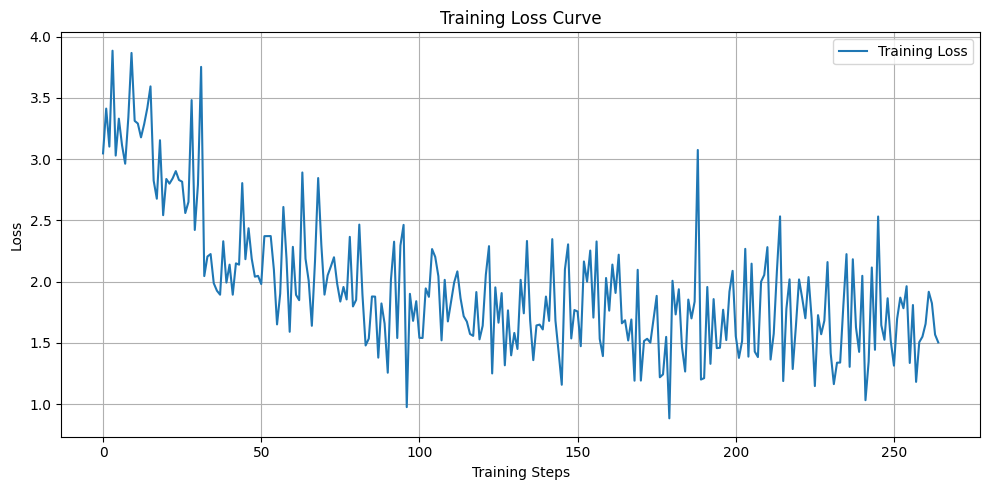

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(loss_values, label = "Training Loss")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()